In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchsummary import summary
import os
import sys
from tqdm.notebook import tqdm
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
    transforms.Resize((64, 64))
])

In [ ]:
train_data = torchvision.datasets.CIFAR10(root="./DATA/", transform=transform, 
                                          download=True)

Extracting ./DATA/cifar-10-python.tar.gz to ./DATA/


In [ ]:
batch_size = 128
train_iter = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [ ]:
def get_discriminator_block(input_channel, output_channel, kernel_size=3, stride=2, 
                            padding=0, final_layer=False, batchNorm=True):
    """
    Function to build the discriminator neural network layer
    
    Parameters : 
    @param input_dim -- a python integer representing the input channel
    @param output_dim -- a python integer representing the output channel
    @param kernel_size -- a python integer representing the kernel size (by default=3)
    @param stride -- a python integer representing the stride value (by default=2)
    @param final_layer -- a boolean value representing whether it is the final layer
    
    Return :
    disc_block -- a discriminator neural block
    """
    disc_block = None
    if not final_layer and batchNorm:
        disc_block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

    elif not final_layer and not batchNorm:
        disc_block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size, stride=stride, padding=padding, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        
    else:
        disc_block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size, stride=stride, padding=padding, bias=False),
        )
        
    return disc_block
        
        

In [ ]:
def get_generator_block(input_channel, output_channel, kernel_size=3, 
                        stride=2, padding=0, final_layer=False):
    
    """
    Function to build the generator block 
    
    Parameters:
    @param input_channel -- a python integer representing the number of input channels
    @param output_channel -- a python integer representing the number of output channels
    @param kernel_size -- a python integer representing the kernel_size (by default=3)
    @param stride -- a python integer representing the stride value (by default=2)
    @param final_layer -- a boolean value indicating if it's for the final layer
    
    Return :
    gen_block -- a generator neural block
    """
    gen_block = None
    if not final_layer:
        gen_block = nn.Sequential(
            nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True)
        )
        
    else:
        gen_block = nn.Sequential(
            nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride=stride, padding=padding,bias=False),
            nn.Tanh()
        )
        
    return gen_block

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self, input_channels, hidden_dim=64):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            get_discriminator_block(input_channels, hidden_dim, kernel_size=4, padding=1, batchNorm=False),
            get_discriminator_block(hidden_dim, hidden_dim*2, kernel_size=4, padding=1),
            get_discriminator_block(hidden_dim*2, hidden_dim*4, kernel_size=4, padding=1),
            get_discriminator_block(hidden_dim*4, hidden_dim*8, kernel_size=4, padding=1),
            get_discriminator_block(hidden_dim*8, 1, kernel_size=4, stride = 1, padding=0, final_layer=True)
        )
        
    def forward(self, image):
        return self.disc(image)

In [ ]:
class Generator(nn.Module):
    
    def __init__(self, latent_dim, im_channels=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.gen = nn.Sequential(
            get_generator_block(latent_dim, hidden_dim*8, kernel_size=4, stride=1),
            get_generator_block(hidden_dim*8, hidden_dim*4, kernel_size=4, padding=1),
            get_generator_block(hidden_dim*4, hidden_dim*2, kernel_size=4, padding=1),
            get_generator_block(hidden_dim*2, hidden_dim, kernel_size=4, padding=1),
            get_generator_block(hidden_dim, im_channels, kernel_size=4, padding=1, final_layer=True)
        )
        
    def unsqueeze_noise(self, noise):
        """
        Reshapes the noise into height of 1 and width of 1 
        and number of channels = latent_dim
        """
        return noise.view(len(noise), self.latent_dim, 1, 1)
    
    def forward(self, noise):
        noise = self.unsqueeze_noise(noise)
        return self.gen(noise)

In [ ]:
def get_noise(batch_size, latent_dim, device):
    """
    Function to generate noise from Normal Distribution
    
    Parameters:
    @param batch_size -- the batch size
    @param latent_dim -- the latent dimension of the noise
    
    Return:
    @ret noise -- the noise vector
    """
    noise = torch.randn(batch_size, latent_dim, device=device)
    return noise

In [ ]:
def get_discriminator_loss(G, D, criterion, real_data, latent_dim, 
                          batch_size, device):
    """
    Function to compute the discriminator loss
    
    Parameters:
    @param G -- the Generator Network
    @param D -- the Discriminator Network
    @param criterion -- the loss function 
    @param real_data -- the authentic data 
    @param latent_dim -- the dimension to create noise
    @param batch_size -- the batch size 
    @param device -- the device to use (cpu/cuda)
    
    Return:
    @ret disc_loss -- the discriminator loss
    """
    
    real_pred = D(real_data)
    ones_ = torch.ones_like(real_pred).to(device)
    d_real_loss = criterion(real_pred, ones_)
    
    noise = get_noise(batch_size, latent_dim, device)
    fake_data = G(noise).detach()
    fake_pred = D(fake_data)
    zeros_ = torch.zeros_like(fake_pred)
    d_fake_loss = criterion(fake_pred, zeros_)
    
    disc_loss = 0.5 * (d_real_loss + d_fake_loss)
    
    return disc_loss
    

In [ ]:
def get_generator_loss(G, D, criterion, latent_dim, batch_size, device):
    """
    Function to calculate the generator loss
    
    Parameters:
    @param G -- the Generator Network
    @param D -- the Discriminator Network
    @param criterion -- the Loss function
    @param latent_dim -- the latent dimension of the noise
    @param batch_size -- a python integer representing the batch size
    @param device -- the device whether it is cpu or cuda
    
    Return :
    gen_loss -- the Generator loss
    """
    
    noise = get_noise(batch_size, latent_dim, device)
    fake_data = G(noise)
    fake_pred = D(fake_data)
    ones_ = torch.ones_like(fake_pred)
    gen_loss = criterion(fake_pred, ones_)
    return gen_loss

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device used : {device}")

Device used : cuda:0


In [ ]:
latent_dim = 100
G = Generator(latent_dim).to(device)
D = Discriminator(3).to(device)

g_optim = torch.optim.Adam(G.parameters(), lr=1e-4*2, betas=(0.5, 0.999))
d_optim = torch.optim.Adam(D.parameters(), lr=1e-4*2, betas=(0.5, 0.999))

In [ ]:
summary(G, (100,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [ ]:
summary(D, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
Total params: 2,765,568
Trainable params: 2,765,568
Non-trainable params: 0
---------------------------

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        torch.nn.init.normal_(m.bias, mean=0)

In [ ]:
G = G.apply(init_weights)
D = D.apply(init_weights)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
if not os.path.exists("./IMAGES/DCGANs_CIFAR/"):
    os.mkdir("./IMAGES/DCGANs_CIFAR/")

In [ ]:
def train(data_iter, G, D, criterion, g_optim, d_optim, latent_dim, 
          epochs=200, save=True, device=device):
    
    g_losses = []
    d_losses = []
    
    for epoch in range(epochs):
        
        d_loss = []
        g_loss = []
        batch_size = 0
        
        for inputs, _ in tqdm(data_iter):
            
            inputs = inputs.to(device)
            
            batch_size = inputs.size(0)
            
            ###################################
            ##### TRAIN DISCRIMINATOR ######
            ##################################
            
            d_optim.zero_grad()
            dLoss = get_discriminator_loss(G, D, criterion, inputs, 
                                           latent_dim, batch_size, device)
            
            dLoss.backward()
            d_optim.step()
            
            d_loss.append(dLoss.item())
            
            ###################################
            ########## TRAIN GENERATOR #######
            ##################################

            g_optim.zero_grad()
            gLoss = get_generator_loss(G, D, criterion, latent_dim, batch_size, device)

            gLoss.backward()
            g_optim.step()
            g_loss.append(gLoss.item())
            
            
        d_loss = np.mean(d_loss)
        g_loss = np.mean(g_loss)
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
        print(f"Epoch : {epoch+1}/{epochs} || Disc Loss : {d_loss} || Gen Loss: {g_loss}")
        
        if save and epoch % 10 == 0:
            noise = get_noise(batch_size, latent_dim, device)
            fake_img = G(noise)
            save_image(fake_img, f"./IMAGES/DCGANs_CIFAR/gan-{epoch+1}.png", normalize=True)
    
    return g_losses, d_losses

In [ ]:
g_losses, d_losses = train(train_iter, G, D, criterion, g_optim, d_optim, 
                           latent_dim)


Epoch : 1/200 || Disc Loss : 0.2417328821809586 || Gen Loss: 2.570556781938314



Epoch : 2/200 || Disc Loss : 0.14632664396858697 || Gen Loss: 3.4128739884232773



Epoch : 3/200 || Disc Loss : 0.09988296307418543 || Gen Loss: 4.42931335751736



Epoch : 4/200 || Disc Loss : 0.184983928758732 || Gen Loss: 4.128552324317225



Epoch : 5/200 || Disc Loss : 0.17728957783757135 || Gen Loss: 3.947334653695526



Epoch : 6/200 || Disc Loss : 0.16199548789383392 || Gen Loss: 4.007234200339793



Epoch : 7/200 || Disc Loss : 0.2183274078585417 || Gen Loss: 3.7807025298133228



Epoch : 8/200 || Disc Loss : 0.17264538285705974 || Gen Loss: 3.86849139184903



Epoch : 9/200 || Disc Loss : 0.24195754836352729 || Gen Loss: 3.573832766993729



Epoch : 10/200 || Disc Loss : 0.252906790086547 || Gen Loss: 3.6620280229965285



Epoch : 11/200 || Disc Loss : 0.30372049291725356 || Gen Loss: 3.2121927719598973



Epoch : 12/200 || Disc Loss : 0.16228807641698234 || Gen Loss: 4.186091024990734



Epoch : 13/200 || Disc Loss : 0.26255071821117587 || Gen Loss: 3.465902915181559



Epoch : 14/200 || Disc Loss : 0.3095091857990283 || Gen Loss: 3.2088486370535287



Epoch : 15/200 || Disc Loss : 0.3056237192400505 || Gen Loss: 3.1776177924879065



Epoch : 16/200 || Disc Loss : 0.23047211276048132 || Gen Loss: 3.7072838547132205



Epoch : 17/200 || Disc Loss : 0.24702692478704635 || Gen Loss: 3.389784458048089



Epoch : 18/200 || Disc Loss : 0.26332930242761854 || Gen Loss: 3.1983197963298737



Epoch : 19/200 || Disc Loss : 0.2345494723895474 || Gen Loss: 3.530355134469164



Epoch : 20/200 || Disc Loss : 0.2708034155380619 || Gen Loss: 3.111737876649365



Epoch : 21/200 || Disc Loss : 0.2522775988092127 || Gen Loss: 3.2686861396309874



Epoch : 22/200 || Disc Loss : 0.27321149741092227 || Gen Loss: 3.0731499398608344



Epoch : 23/200 || Disc Loss : 0.23241313950746983 || Gen Loss: 3.3772317618226912



Epoch : 24/200 || Disc Loss : 0.22900816449738295 || Gen Loss: 3.347042222690704



Epoch : 25/200 || Disc Loss : 0.22442733816733426 || Gen Loss: 3.5443977605452632



Epoch : 26/200 || Disc Loss : 0.24085539530503 || Gen Loss: 3.5247820714474334



Epoch : 27/200 || Disc Loss : 0.28661857049762157 || Gen Loss: 3.1164296253005523



Epoch : 28/200 || Disc Loss : 0.22841168550745872 || Gen Loss: 3.3085624876877535



Epoch : 29/200 || Disc Loss : 0.05657098576357431 || Gen Loss: 5.132943887558892



Epoch : 30/200 || Disc Loss : 0.30489145794137834 || Gen Loss: 2.986114056483197



Epoch : 31/200 || Disc Loss : 0.21875717173404324 || Gen Loss: 3.5460464811843373



Epoch : 32/200 || Disc Loss : 0.17095900947451972 || Gen Loss: 4.20099247328918



Epoch : 33/200 || Disc Loss : 0.2341275753898789 || Gen Loss: 3.5445340018733726



Epoch : 34/200 || Disc Loss : 0.22736031837437465 || Gen Loss: 3.652408347757476



Epoch : 35/200 || Disc Loss : 0.22361751808010785 || Gen Loss: 3.5248670735970484



Epoch : 36/200 || Disc Loss : 0.09007529737954825 || Gen Loss: 4.916668906012438



Epoch : 37/200 || Disc Loss : 0.2144849466414803 || Gen Loss: 3.816959323261476



Epoch : 38/200 || Disc Loss : 0.2673286242896448 || Gen Loss: 2.891626252733228



Epoch : 39/200 || Disc Loss : 0.2195338291066039 || Gen Loss: 3.6539589325180444



Epoch : 40/200 || Disc Loss : 0.15850569707159276 || Gen Loss: 4.5916171499368295



Epoch : 41/200 || Disc Loss : 0.2525449487573617 || Gen Loss: 3.1820647170661642



Epoch : 42/200 || Disc Loss : 0.17750458082522425 || Gen Loss: 3.9714534758634485



Epoch : 43/200 || Disc Loss : 0.24281582139823063 || Gen Loss: 3.233962024716884



Epoch : 44/200 || Disc Loss : 0.19407847583504712 || Gen Loss: 4.0773193846104485



Epoch : 45/200 || Disc Loss : 0.18945804263805718 || Gen Loss: 3.894345794073151



Epoch : 46/200 || Disc Loss : 0.054276719910588085 || Gen Loss: 5.023266851844842



Epoch : 47/200 || Disc Loss : 0.006850424621616254 || Gen Loss: 5.587416751305465



Epoch : 48/200 || Disc Loss : 0.002663833369641467 || Gen Loss: 7.23214624848817



Epoch : 49/200 || Disc Loss : 0.05465265855138354 || Gen Loss: 6.934694356625648



Epoch : 50/200 || Disc Loss : 0.10092532091662097 || Gen Loss: 4.406289263928542



Epoch : 51/200 || Disc Loss : 0.15583952609270982 || Gen Loss: 4.092493746975137



Epoch : 52/200 || Disc Loss : 0.23591581094638467 || Gen Loss: 3.397385888411413



Epoch : 53/200 || Disc Loss : 0.22800447765792556 || Gen Loss: 3.4050364936472697



Epoch : 54/200 || Disc Loss : 0.22545534707120526 || Gen Loss: 4.032219340926914



Epoch : 55/200 || Disc Loss : 0.21746995239494765 || Gen Loss: 3.587885680111863



Epoch : 56/200 || Disc Loss : 0.1985401336521701 || Gen Loss: 3.8023776186789715



Epoch : 57/200 || Disc Loss : 0.22563469932501531 || Gen Loss: 3.988767789769084



Epoch : 58/200 || Disc Loss : 0.2453158810583498 || Gen Loss: 3.406241905096623



Epoch : 59/200 || Disc Loss : 0.26408290533382267 || Gen Loss: 2.9238893019983454



Epoch : 60/200 || Disc Loss : 0.24186867007347362 || Gen Loss: 3.575176210396121



Epoch : 61/200 || Disc Loss : 0.22750030713968095 || Gen Loss: 3.618303477116253



Epoch : 62/200 || Disc Loss : 0.15373365909127337 || Gen Loss: 4.733957508032678



Epoch : 63/200 || Disc Loss : 0.2007711757974261 || Gen Loss: 4.185792676308843



Epoch : 64/200 || Disc Loss : 0.2300280141048705 || Gen Loss: 3.323549317443729



Epoch : 65/200 || Disc Loss : 0.2096582700446596 || Gen Loss: 4.067021480525661



Epoch : 66/200 || Disc Loss : 0.19592631561890045 || Gen Loss: 4.204923269006817



Epoch : 67/200 || Disc Loss : 0.21745201283494187 || Gen Loss: 3.7421552181682167



Epoch : 68/200 || Disc Loss : 0.1921597338645407 || Gen Loss: 3.9984406180074794



Epoch : 69/200 || Disc Loss : 0.273541561441722 || Gen Loss: 3.052000266702279



Epoch : 70/200 || Disc Loss : 0.24563921774994185 || Gen Loss: 3.617012368985857



Epoch : 71/200 || Disc Loss : 0.1505419075515245 || Gen Loss: 4.616612651673576



Epoch : 72/200 || Disc Loss : 0.20953759147971393 || Gen Loss: 4.063392114463865



Epoch : 73/200 || Disc Loss : 0.26489518207001866 || Gen Loss: 3.2646766172321824



Epoch : 74/200 || Disc Loss : 0.24086106087729012 || Gen Loss: 3.4712502259208495



Epoch : 75/200 || Disc Loss : 0.21493726660875018 || Gen Loss: 3.737365395147417



Epoch : 76/200 || Disc Loss : 0.1548358701042059 || Gen Loss: 4.577346761703796



Epoch : 77/200 || Disc Loss : 0.28912423844651686 || Gen Loss: 3.332013022918095



Epoch : 78/200 || Disc Loss : 0.084094887490526 || Gen Loss: 5.030047659564506



Epoch : 79/200 || Disc Loss : 0.19067483208775807 || Gen Loss: 4.155264157257435



Epoch : 80/200 || Disc Loss : 0.22320961780027937 || Gen Loss: 3.460519977139763



Epoch : 81/200 || Disc Loss : 0.16903860351461394 || Gen Loss: 4.445141927331991



Epoch : 82/200 || Disc Loss : 0.23537258312696843 || Gen Loss: 3.1990670919980464



Epoch : 83/200 || Disc Loss : 0.27424845472216375 || Gen Loss: 3.201702114370892



Epoch : 84/200 || Disc Loss : 0.23895563750261026 || Gen Loss: 3.6850776798166263



Epoch : 85/200 || Disc Loss : 0.07990789018548153 || Gen Loss: 5.5565762902750535



Epoch : 86/200 || Disc Loss : 0.18811831857382064 || Gen Loss: 3.9977051818253866



Epoch : 87/200 || Disc Loss : 0.21636098554379324 || Gen Loss: 4.045912306121675



Epoch : 88/200 || Disc Loss : 0.1973655415910875 || Gen Loss: 3.8899049243757515



Epoch : 89/200 || Disc Loss : 0.1732808241240747 || Gen Loss: 3.962780322881881



Epoch : 90/200 || Disc Loss : 0.20794392594278022 || Gen Loss: 4.2682333028093415



Epoch : 91/200 || Disc Loss : 0.20398116559373772 || Gen Loss: 3.6073771861126964



Epoch : 92/200 || Disc Loss : 0.23898903648187395 || Gen Loss: 3.565785546608115



Epoch : 93/200 || Disc Loss : 0.1251275154910541 || Gen Loss: 5.348821956211167



Epoch : 94/200 || Disc Loss : 0.2262739415037567 || Gen Loss: 3.5611285791753806



Epoch : 95/200 || Disc Loss : 0.20916340013375254 || Gen Loss: 4.106416415423155



Epoch : 96/200 || Disc Loss : 0.1100557937118461 || Gen Loss: 5.350752961876489



Epoch : 97/200 || Disc Loss : 0.20666153446945082 || Gen Loss: 3.329651475981678



Epoch : 98/200 || Disc Loss : 0.2012903870028608 || Gen Loss: 3.724019600592954



Epoch : 99/200 || Disc Loss : 0.20121113030204807 || Gen Loss: 4.031738643947155



Epoch : 100/200 || Disc Loss : 0.19991761661531246 || Gen Loss: 4.276953738565078



Epoch : 101/200 || Disc Loss : 0.1949744881098004 || Gen Loss: 4.080583884230698



Epoch : 102/200 || Disc Loss : 0.1513654990678491 || Gen Loss: 4.512277389510327



Epoch : 103/200 || Disc Loss : 0.18138300029136945 || Gen Loss: 4.414323322908462



Epoch : 104/200 || Disc Loss : 0.11759717212735361 || Gen Loss: 5.213346628950896



Epoch : 105/200 || Disc Loss : 0.20603201396601356 || Gen Loss: 3.864056975661141



Epoch : 106/200 || Disc Loss : 0.12849606248333365 || Gen Loss: 4.785750606848472



Epoch : 107/200 || Disc Loss : 0.20205641818492462 || Gen Loss: 3.3491119324227276



Epoch : 108/200 || Disc Loss : 0.18220720142352365 || Gen Loss: 4.455295206476932



Epoch : 109/200 || Disc Loss : 0.2011367406670327 || Gen Loss: 4.460769058287791



Epoch : 110/200 || Disc Loss : 0.17571470363612246 || Gen Loss: 3.92201947092714



Epoch : 111/200 || Disc Loss : 0.17645352658838906 || Gen Loss: 4.720688666726681



Epoch : 112/200 || Disc Loss : 0.1792118402574297 || Gen Loss: 4.6067168541136345



Epoch : 113/200 || Disc Loss : 0.17197398372266032 || Gen Loss: 3.8332669020575634



Epoch : 114/200 || Disc Loss : 0.19956306732476145 || Gen Loss: 4.083407427732344



Epoch : 115/200 || Disc Loss : 0.18999907088137286 || Gen Loss: 4.2249079519847665



Epoch : 116/200 || Disc Loss : 0.19321380135633917 || Gen Loss: 4.702181038488992



Epoch : 117/200 || Disc Loss : 0.16282054638285237 || Gen Loss: 3.5908201807238105



Epoch : 118/200 || Disc Loss : 0.2551141347658113 || Gen Loss: 3.599928822883097



Epoch : 119/200 || Disc Loss : 0.20294437033120993 || Gen Loss: 4.037409135185735



Epoch : 120/200 || Disc Loss : 0.13879437202288794 || Gen Loss: 4.742927384155486



Epoch : 121/200 || Disc Loss : 0.005934379727166096 || Gen Loss: 7.9902038482753825



Epoch : 122/200 || Disc Loss : 0.10748426340055316 || Gen Loss: 4.600154661976011



Epoch : 123/200 || Disc Loss : 0.16701901354112417 || Gen Loss: 3.75954415945603



Epoch : 124/200 || Disc Loss : 0.2454526007792953 || Gen Loss: 3.594637715824559



Epoch : 125/200 || Disc Loss : 0.22407497410469537 || Gen Loss: 3.6762134431869677



Epoch : 126/200 || Disc Loss : 0.04994065879343819 || Gen Loss: 6.077121298250449



Epoch : 127/200 || Disc Loss : 0.1031554330452902 || Gen Loss: 5.690042895372109



Epoch : 128/200 || Disc Loss : 0.13220835272746775 || Gen Loss: 4.2828219579997215



Epoch : 129/200 || Disc Loss : 0.1803699440871844 || Gen Loss: 4.34034256364101



Epoch : 130/200 || Disc Loss : 0.18648745066366013 || Gen Loss: 4.110337131200861



Epoch : 131/200 || Disc Loss : 0.16791006178646337 || Gen Loss: 4.007570651578991



Epoch : 132/200 || Disc Loss : 0.20563167126935936 || Gen Loss: 4.158586119501957



Epoch : 133/200 || Disc Loss : 0.1776740990588507 || Gen Loss: 4.2667338602997145



Epoch : 134/200 || Disc Loss : 0.18668413736328693 || Gen Loss: 3.9634730995768477



Epoch : 135/200 || Disc Loss : 0.14348969410014006 || Gen Loss: 5.586408419569697



Epoch : 136/200 || Disc Loss : 0.15823390291425174 || Gen Loss: 4.1819238384752095



Epoch : 137/200 || Disc Loss : 0.16937426123579027 || Gen Loss: 4.818847032368678



Epoch : 138/200 || Disc Loss : 0.17068170881255523 || Gen Loss: 4.1470250704132505



Epoch : 139/200 || Disc Loss : 0.13060656372178464 || Gen Loss: 5.173701017085091



Epoch : 140/200 || Disc Loss : 0.1383750468671225 || Gen Loss: 4.92436346554619



Epoch : 141/200 || Disc Loss : 0.1297337767601301 || Gen Loss: 5.317218640646477



Epoch : 142/200 || Disc Loss : 0.20069170175739529 || Gen Loss: 3.6333845186873774



Epoch : 143/200 || Disc Loss : 0.1519733781045329 || Gen Loss: 5.019670969732773



Epoch : 144/200 || Disc Loss : 0.1998232828293596 || Gen Loss: 3.854786783271014



Epoch : 145/200 || Disc Loss : 0.10291639914332866 || Gen Loss: 5.713426633452149



Epoch : 146/200 || Disc Loss : 0.11981577623178206 || Gen Loss: 5.538749966333034



Epoch : 147/200 || Disc Loss : 0.19830925487037843 || Gen Loss: 4.082004867910939



Epoch : 148/200 || Disc Loss : 0.19006193337692281 || Gen Loss: 4.659520301777308



Epoch : 149/200 || Disc Loss : 0.15839549217807383 || Gen Loss: 4.569017533808361



Epoch : 150/200 || Disc Loss : 0.1258302497994 || Gen Loss: 5.85139531943747



Epoch : 151/200 || Disc Loss : 0.09642494381851274 || Gen Loss: 6.354697486876158



Epoch : 152/200 || Disc Loss : 0.1644509834299326 || Gen Loss: 3.8658223855833205



Epoch : 153/200 || Disc Loss : 0.16452560216442103 || Gen Loss: 5.337738278576785



Epoch : 154/200 || Disc Loss : 0.15858878315556818 || Gen Loss: 3.9919247307763746



Epoch : 155/200 || Disc Loss : 0.17943204382834646 || Gen Loss: 4.2065793571590575



Epoch : 156/200 || Disc Loss : 0.17068865737267647 || Gen Loss: 4.843829685555058



Epoch : 157/200 || Disc Loss : 0.17267959321910978 || Gen Loss: 3.977422495818604



Epoch : 158/200 || Disc Loss : 0.12581196161480668 || Gen Loss: 5.312957324317548



Epoch : 159/200 || Disc Loss : 0.12365534187026876 || Gen Loss: 4.985742781492298



Epoch : 160/200 || Disc Loss : 0.2372268070912678 || Gen Loss: 3.984563273458635



Epoch : 161/200 || Disc Loss : 0.08087345596287956 || Gen Loss: 6.177186763924582



Epoch : 162/200 || Disc Loss : 0.13721187121670722 || Gen Loss: 3.7497650755335914



Epoch : 163/200 || Disc Loss : 0.23235793092199947 || Gen Loss: 4.021433776458892



Epoch : 164/200 || Disc Loss : 0.13666060143110195 || Gen Loss: 5.053478711994503



Epoch : 165/200 || Disc Loss : 0.1230733187809011 || Gen Loss: 6.3697783197426485



Epoch : 166/200 || Disc Loss : 0.1628299534969601 || Gen Loss: 4.18837154979523



Epoch : 167/200 || Disc Loss : 0.19163707613184586 || Gen Loss: 4.568180903573656



Epoch : 168/200 || Disc Loss : 0.17547360309423482 || Gen Loss: 4.213217265694342



Epoch : 169/200 || Disc Loss : 0.1750573372099009 || Gen Loss: 4.724414970389927



Epoch : 170/200 || Disc Loss : 0.06725810375548434 || Gen Loss: 6.137994810155786



Epoch : 171/200 || Disc Loss : 0.003193899328439527 || Gen Loss: 9.93257846368853



Epoch : 172/200 || Disc Loss : 0.07665664102527876 || Gen Loss: 6.046473231776368



Epoch : 173/200 || Disc Loss : 0.12145646557832956 || Gen Loss: 4.95818840864155



Epoch : 174/200 || Disc Loss : 0.10799518401247432 || Gen Loss: 4.746959535974313



Epoch : 175/200 || Disc Loss : 0.1497478634496044 || Gen Loss: 4.578747896667611



Epoch : 176/200 || Disc Loss : 0.1515010275742244 || Gen Loss: 4.170884203051439



Epoch : 177/200 || Disc Loss : 0.14620703144941022 || Gen Loss: 5.606663412185829



Epoch : 178/200 || Disc Loss : 0.15511097784092784 || Gen Loss: 4.367643938059239



Epoch : 179/200 || Disc Loss : 0.1402522103655982 || Gen Loss: 5.1788521513939525



Epoch : 180/200 || Disc Loss : 0.11190209887336608 || Gen Loss: 5.963156132937392



Epoch : 181/200 || Disc Loss : 0.16595102976547624 || Gen Loss: 5.153056214130713



Epoch : 182/200 || Disc Loss : 0.1815315495683428 || Gen Loss: 3.8368700925651416



Epoch : 183/200 || Disc Loss : 0.16446302107123978 || Gen Loss: 4.833164122894101



Epoch : 184/200 || Disc Loss : 0.14745836572193413 || Gen Loss: 4.178183714051724



Epoch : 185/200 || Disc Loss : 0.23200264364293993 || Gen Loss: 4.225566842081144



Epoch : 186/200 || Disc Loss : 0.16027662816841978 || Gen Loss: 4.579485551733702



Epoch : 187/200 || Disc Loss : 0.19475995054926432 || Gen Loss: 3.925686420483367



Epoch : 188/200 || Disc Loss : 0.18064759447700238 || Gen Loss: 4.0816651642080775



Epoch : 189/200 || Disc Loss : 0.1472703321243498 || Gen Loss: 4.724194112267164



Epoch : 190/200 || Disc Loss : 0.05137467104626424 || Gen Loss: 8.784989905498369



Epoch : 191/200 || Disc Loss : 0.12348014708903744 || Gen Loss: 4.200539395746673



Epoch : 192/200 || Disc Loss : 0.15956525535017843 || Gen Loss: 4.66460870943792



Epoch : 193/200 || Disc Loss : 0.1430404446209301 || Gen Loss: 5.001835833319113



Epoch : 194/200 || Disc Loss : 0.18921323383414268 || Gen Loss: 4.560068448934028



Epoch : 195/200 || Disc Loss : 0.13129694322272248 || Gen Loss: 4.882012019113725



Epoch : 196/200 || Disc Loss : 0.14735483808463867 || Gen Loss: 5.568068748663949



Epoch : 197/200 || Disc Loss : 0.14819765050375663 || Gen Loss: 4.379565075363802



Epoch : 198/200 || Disc Loss : 0.12539196000667438 || Gen Loss: 5.167806669936308



Epoch : 199/200 || Disc Loss : 0.15233308838351683 || Gen Loss: 5.417880012403669



Epoch : 200/200 || Disc Loss : 0.1689246792321378 || Gen Loss: 4.63412984852945


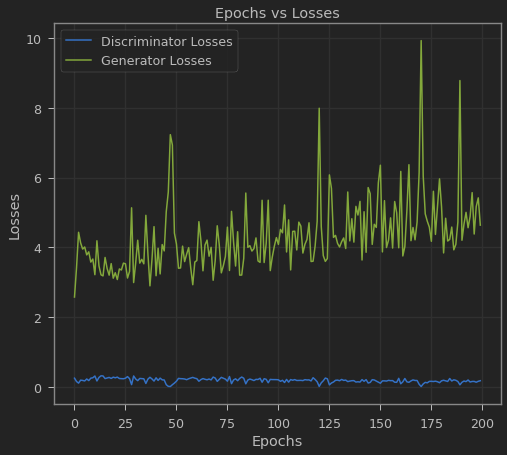

In [ ]:
plt.title("Epochs vs Losses")
plt.plot(d_losses, label="Discriminator Losses")
plt.plot(g_losses, label="Generator Losses")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()

In [32]:
!zip images.zip IMAGES/DCGANs_CIFAR/*.*

  adding: IMAGES/DCGANs_CIFAR/gan-101.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-111.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-11.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-121.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-131.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-141.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-151.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-161.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-171.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-181.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-191.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-1.png (deflated 1%)
  adding: IMAGES/DCGANs_CIFAR/gan-21.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-31.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-41.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-51.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-61.png (deflated 0%)
  adding: IMAGES/DCGANs_CIFAR/gan-71.png (deflated 0%)
 

In [33]:
from google.colab import files
files.download("images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>